# Library import

In [156]:
import pandas as pd
from tqdm import tqdm

from functions import print_shape, df_security_code

# some example data
import numpy as np
import pandas
import tensorflow as tf

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss
from tqdm import tqdm_notebook,tqdm
from itertools import product

from sklearn.metrics import mean_absolute_percentage_error as MAPE

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [157]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open(".mlflow_uri").read().strip()

warnings.filterwarnings('ignore')

# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

# Data import

In [158]:
test_data = pd.read_csv('data/curr_test_data.csv', parse_dates=['Date'], index_col=[0])
train_data = pd.read_csv('data/curr_train_data.csv', parse_dates=['Date'], index_col=[0])

In [160]:
decomposition = ['ad_Close','detrend_ad_Close', 'trend_ad_Close', 'season_ad_Close', 'error_ad_Close']
test_data[decomposition].head()

,ad_Close,detrend_ad_Close,trend_ad_Close,season_ad_Close,error_ad_Close
1178,3735.0,3735.0,3721.083333,5.994729,7.921937
1179,3725.0,3725.0,3703.666667,4.535328,16.798006
1180,3715.0,3715.0,3687.750000,19.255413,7.994587
1181,3795.0,3795.0,3675.000000,12.578063,107.421937
1182,3745.0,3745.0,3663.166667,-2.334330,84.167664


In [161]:
test_data.drop('RowId',axis=1,inplace=True)
train_data.drop('RowId',axis=1,inplace=True)

In [162]:
test_8194 = test_data.query('SecuritiesCode == 8194')
train_8194 = train_data.query('SecuritiesCode == 8194')

# EDA

In [163]:
# Test for stationarity 

def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation    
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()

    #rolling_mean = pd.DataFrame(rolling_mean).query('Close > 0')

    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)

    
#stationarity_test(test_data['ad_Close'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -2.057966
p-value: 0.261749
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.595679
p-value: 0.010000
----------------------------------------


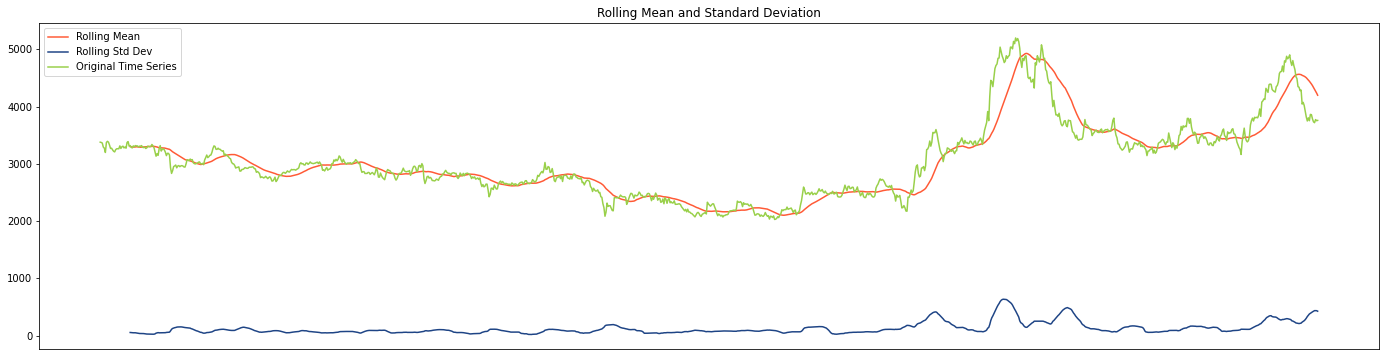

In [164]:
stationarity_test(train_8194['ad_Close'])

In [167]:
features_to_use = ['Date','ExpectedDividend', 'SupervisionFlag',
       'ad_Open', 'ad_High', 'ad_Low', 'ad_Close', 'ad_Volume', 'ad_Target',
       'RSI', 'Return', 'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year',
       'week', 'Volatility_week', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos', 'Year_sin', 'Year_cos', 'Profit', 'NetSales', 'margin',
       'win_quarter_growth', 'rev_quarter_growth', 'margin_growth']

In [168]:
test = train_8194[features_to_use]
test = test.set_index('Date').dropna()

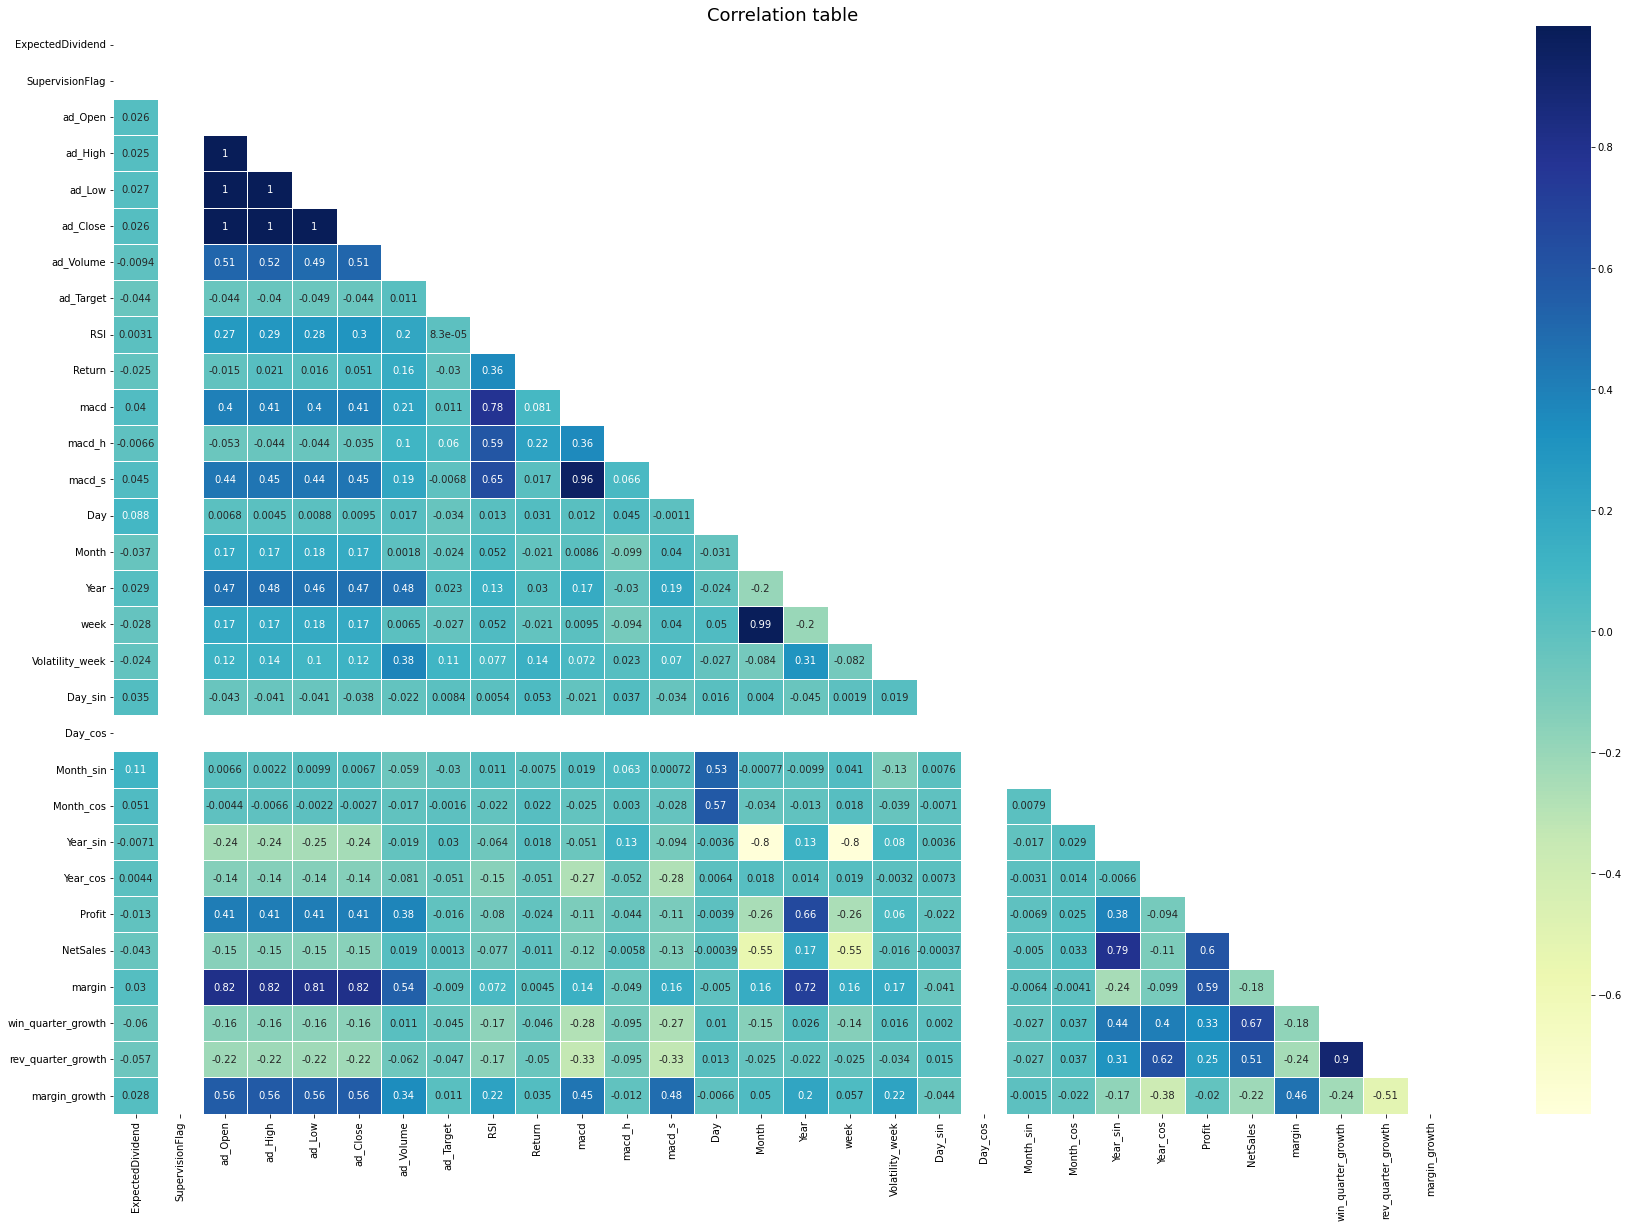

In [169]:
from functions import plot_corr
plot_corr(test, 30,20)

In [170]:
train_data.SecuritiesCode.unique()

array([8194, 8198, 8200, ..., 8179, 8182, 8185])

# VAR test-run

In [171]:
var_feat = ['Date', 'SecuritiesCode' , 'ad_Close']
var_test = train_data.query('SecuritiesCode == [8194, 8198, 8200]')[var_feat]
var_test = var_test.sort_values('Date').reset_index().drop('index', axis=1)

In [172]:
var_test.head()

,Date,SecuritiesCode,ad_Close
0,2017-01-04,8194,3380.0
1,2017-01-04,8198,1902.0
2,2017-01-04,8200,2298.0
3,2017-01-05,8194,3375.0
4,2017-01-05,8198,1907.0


In [173]:
var_test.SecuritiesCode.unique()[:100]

array([8194, 8198, 8200])

In [176]:
def transform(df, amount = 2001 ,feature = 'ad_Close'):
    from functions import df_security_code
    feat = ['Date', 'SecuritiesCode' , feature]
    df = df[feat]
    con_df = pd.DataFrame()
    unique_codes = df.SecuritiesCode.unique()[:amount]

    for cod in tqdm(unique_codes):
        if cod != 4684 or cod != 4686: 
            df_code = df_security_code(df, cod)
            df_code = df_code[['Date', feature]].set_index(['Date'])
            df_code = df_code.rename(columns = {feature: 'ad_Close_'+str(cod)})
            con_df = pd.concat([con_df, df_code], axis=1)
            
    return con_df

In [177]:
train_data.SecuritiesCode.unique()[1128:1130]

array([4684, 4686])

# VAR - Model 1

In [201]:
stock_count = 3
new_df = transform2(train_data, amount=stock_count)

100%|██████████| 3/3 [00:00<00:00, 47.31it/s]


In [204]:
new_df.head()

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2017-01-04,3380.0,1902.0,2298.0
2017-01-05,3375.0,1907.0,2299.0
2017-01-06,3365.0,1905.0,2302.0
2017-01-10,3295.0,1906.0,2323.0
2017-01-11,3275.0,1915.0,2324.0


In [180]:
from functions import missingValues
new_df.dropna(axis=1, inplace = True)


In [181]:
split = -10
train_df = new_df[:split]
test_df = new_df[split:]

## Testing

In [183]:
# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# grangers_causation_matrix(train_df, variables = train_df.columns)   

In [184]:
# def adfuller_test(series, signif=0.05, name='', verbose=False):
#     """Perform ADFuller to test for Stationarity of given series and print report"""
#     r = adfuller(series, autolag='AIC')
#     output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
#     p_value = output['pvalue'] 
#     def adjust(val, length= 6): return str(val).ljust(length)

#     # Print Summary
#     print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
#     print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
#     print(f' Significance Level    = {signif}')
#     print(f' Test Statistic        = {output["test_statistic"]}')
#     print(f' No. Lags Chosen       = {output["n_lags"]}')

#     for key,val in r[4].items():
#         print(f' Critical value {adjust(key)} = {round(val, 3)}')

#     if p_value <= signif:
#         print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
#         print(f" => Series is Stationary.")
#     else:
#         print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
#         print(f" => Series is Non-Stationary.")  

In [185]:
# for name, column in new_df.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [187]:
# # ADF Test on each column of 1st Differences Dataframe
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

## Training

In [186]:
df_differenced = train_df.diff().dropna()

In [188]:
model = VAR(df_differenced)

In [189]:
model = VAR(df_differenced)

x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,21.62,21.63*,2.444e+09,21.62*
1,21.61*,21.66,2.416e+09*,21.63
2,21.61,21.70,2.416e+09,21.64
3,21.61,21.74,2.427e+09,21.66
4,21.61,21.78,2.436e+09,21.68
5,21.62,21.83,2.461e+09,21.70
6,21.63,21.88,2.475e+09,21.72
7,21.64,21.93,2.501e+09,21.75
8,21.65,21.98,2.526e+09,21.77
9,21.64,22.01,2.509e+09,21.78


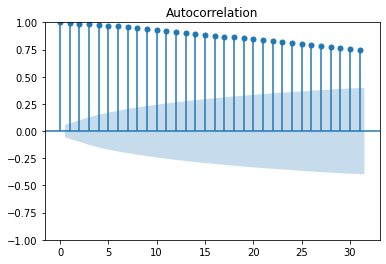

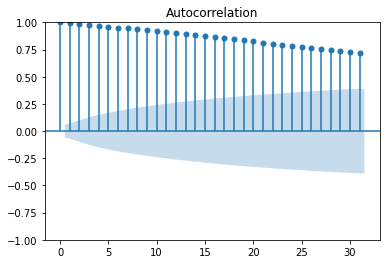

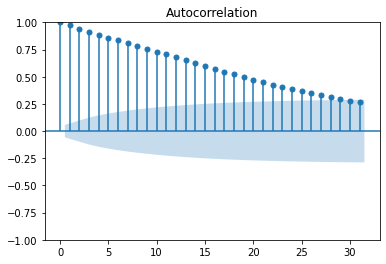

In [ ]:
for i in train_df.columns:
    
    plot_acf(train_df[i])

In [190]:
order = (10,1)

In [191]:
with tf.device('/cpu:0'):
    var_model = VARMAX(train_df, order=order, enforce_stationarity=True)

    model_fitted = var_model.fit(disp=False)
    model_fitted.summary()

In [192]:
n_forcast = split*(-1)-1
start_point = len(train_df)

pred = model_fitted.get_prediction(start=start_point, end=start_point+n_forcast)

predictions = pred.predicted_mean

predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

In [193]:
predictions = pred.predicted_mean

In [194]:
predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

In [195]:
test_df.head()

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2021-10-15,3805.0,2565.0,2279.0
2021-10-18,3755.0,2576.0,2249.0
2021-10-19,3865.0,2599.0,2221.0
2021-10-20,3860.0,2588.0,2214.0
2021-10-21,3785.0,2585.0,2236.0


In [196]:
predictions

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2021-10-15,3734.790853,2562.773084,2296.039273
2021-10-18,3736.054193,2575.970328,2310.500552
2021-10-19,3724.180399,2574.510986,2298.026225
2021-10-20,3701.722166,2578.103250,2298.905811
2021-10-21,3703.226647,2577.410759,2298.177333
2021-10-22,3716.568176,2590.815552,2299.368055
2021-10-25,3681.596079,2582.612067,2293.199516
2021-10-26,3690.408440,2583.885855,2303.303106
2021-10-27,3692.753771,2595.339167,2294.494904


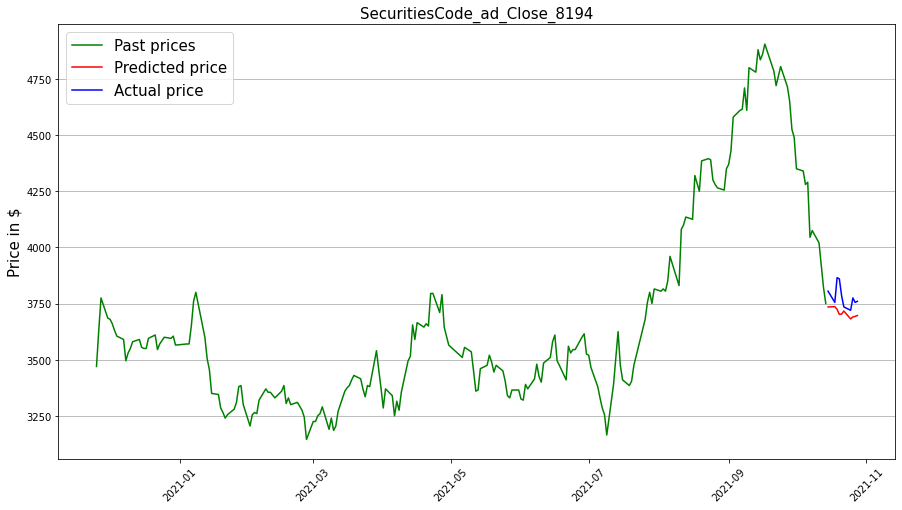

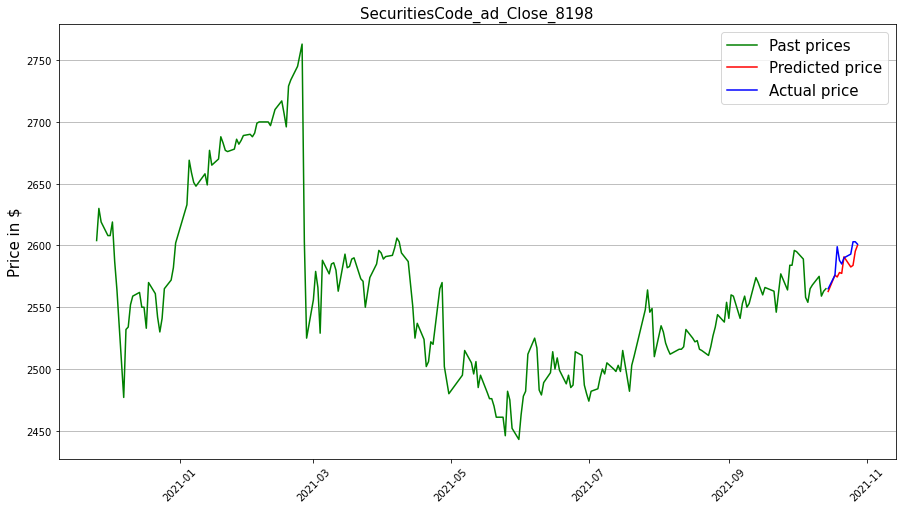

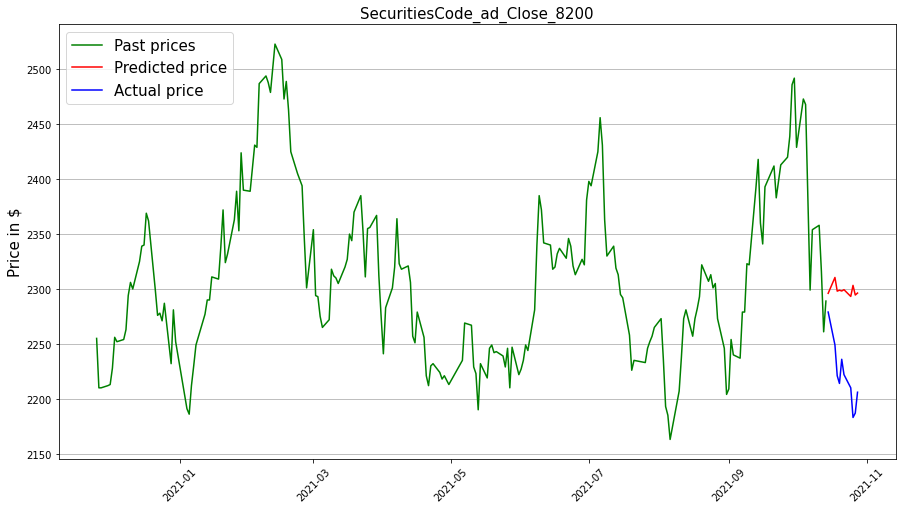

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in predictions.columns:


    plt.figure(figsize=(15,8))

    sns.lineplot(train_df.index[950:], train_df[i][950:], color="green")
    sns.lineplot(predictions.index, predictions[i], color="red")
    sns.lineplot(test_df.index, test_df[i], color="blue")

    plt.ylabel("Price in $",fontsize=15)
    plt.xlabel("",fontsize=1)
    plt.yticks(size = 10)
    plt.xticks(size = 10, rotation = 45)
    plt.title('SecuritiesCode_' + i, fontsize = 15)
    plt.legend(['Past prices','Predicted price', 'Actual price'], fontsize = 15)
    plt.grid(axis='y')
    plt.show()

var_model = VARMAX(train_df, order=(1,22), enforce_stationarity=True)

model_fitted = var_model.fit(disp=False)
model_fitted.summary()

from sklearn.metrics import mean_squared_error as mse
mse(y_pred=predictions["ad_Close_8198"], y_true=test_df["ad_Close_8198"], squared=False)
-> RMSE 10.75

In [198]:
from sklearn.metrics import mean_squared_error as mse
for i in predictions.columns:
    print(mse(y_pred=predictions[i], y_true=test_df[i], squared=False))

85.86280823462756
11.373516096409734
82.5654039057231


SKLEARN: stacking classifier, stacking reverser
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html?highlight=stackingregressor#sklearn.ensemble.StackingRegressor

In [199]:
#from sklearn.metrics import mean_squared_error as mse
average_MAPE_test = []
for i in predictions.columns:
    cur = round((MAPE(y_pred=predictions[i], y_true=test_df[i]))*100,2) 
    average_MAPE_test.append(cur)
    print(f"{i} has a MAPE score of : {cur} %") 
average_MAPE_test = round(sum(average_MAPE_test)/len(average_MAPE_test),2)

ad_Close_8194 has a MAPE score of : 1.94 %
ad_Close_8198 has a MAPE score of : 0.32 %
ad_Close_8200 has a MAPE score of : 3.53 %


In [202]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
model_type = 'VARMAX'
params = {
      "model": model_type,
      "stock_count": stock_count,
      "split_size": split,
      "selected_order_p/q": order,
      "enforce_stationarity": True
  }

In [203]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("test-" + "MAPE", average_MAPE_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
mlflow.end_run()

In [115]:
def basline_prior_value(train_data, test_data):

    test_base = pd.DataFrame()

    for i in tqdm(test_data.columns):
        test_data[f'bp_{i}'] = train_data[i].iloc[-1]        
        test_base = pd.concat([test_base, test_data])



    return test_base


# VAR Model 2

In [124]:
var_mod_2_m = transform(train_data, amount=5, feature='margin')

100%|██████████| 5/5 [00:00<00:00, 97.09it/s]


In [125]:
var_mod_2_m.dropna(inplace=True)

In [127]:
from functions import missingValues
missingValues(var_mod_2_m)

,N_missing,Percentage
ad_Close_8194,0.0,0.0
ad_Close_8198,0.0,0.0
ad_Close_8200,0.0,0.0
ad_Close_8202,0.0,0.0
ad_Close_8203,0.0,0.0


In [128]:
var_mod_2_m.head()

,ad_Close_8194,ad_Close_8198,ad_Close_8200,ad_Close_8202,ad_Close_8203
Date,,,,,
2017-02-14,1.103693,1.05679,4.509145,-2.432923,1.529532
2017-02-15,1.103693,1.05679,4.509145,-2.432923,1.529532
2017-02-16,1.103693,1.05679,4.509145,-2.432923,1.529532
2017-02-17,1.103693,1.05679,4.509145,-2.432923,1.529532
2017-02-20,1.103693,1.05679,4.509145,-2.432923,1.529532


In [129]:
var_mod_2_close = new_df.query('@new_df.index >= "2017-02-14"')

In [ ]:
df_differenced_mod2 = mod2_train_8194.diff().dropna()

model_2 = VAR(df_differenced_mod2)

x = model_2.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,117.4,117.4,9.278e+50,117.4
1,116.0,116.2,2.501e+50,116.1
2,115.6,115.9*,1.591e+50,115.7
3,115.5,116.0,1.396e+50,115.7
4,115.3,116.0,1.240e+50,115.6
5,115.2,116.1,1.124e+50,115.6*
6,115.2,116.2,1.090e+50,115.6
7,115.2,116.3,1.080e+50,115.6
8,115.2,116.5,1.043e+50,115.7
9,115.1,116.6,1.021e+50,115.7


In [ ]:
for i in mod2_train_8194.columns:
    
    plot_acf(mod2_train_8194[i])

In [ ]:
var_model_2 = VARMAX(mod2_train_8194, order=(10,20), enforce_stationarity=True)

model_fitted_2 = var_model_2.fit(disp=False)
model_fitted_2.summary()

In [ ]:
n_forcast = split*(-1)-1
start_point_2 = len(mod2_train_8194)

pred_2 = model_fitted_2.get_prediction(start=start_point_2, end=start_point_2+n_forcast)

predictions_2 = pred_2.predicted_mean

predictions_2 = pd.concat([predictions_2.reset_index(), (mod2_train_8194.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

MLFLOW

In [ ]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

warnings.filterwarnings('ignore')

# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()


#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "altitude_low_meters_mean": altitude_low_meters_mean,
      "altitude_high_meters_mean": altitude_high_meters_mean,
      "altitude_mean_log_mean": altitude_mean_log_mean,
      "fit_intercept": True,
  }

#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "MSE", mse_train)
mlflow.log_metric("test-" + "MSE", mse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

Future tests
- nur 1 Jahr an Daten
- Externe Daten einfügen


In [220]:
def var(df, split = 10, range = 'y', metric = 'MAPE', exog = None, feature = 'ad_Close', stock_count = 3, drop_na = True, drop_axis = 1, maxlags = 12, plot_predicton = False, ml_flow = False):
    """_summary_

    Args:
        df (_type_): _timeseries Dataframe needed_

        split (str, optional): _Days to predict_. Defaults to '10'.

        range (str, optional): _Range of years for the train data_. Defaults to 'y'.

        metric (str, optional): _Metric chosen _. Defaults to 'MAPE'.

        exog (_type_, optional): _External data that should be considered_. Defaults to None.

        feature (str, optional): _Feature that should be predicted_. Defaults to 'ad_Close'.

        stock_count (int, optional): _amount of stocks_. Defaults to 3.

        drop_na (bool, optional): _Drops all features with NaN values_. Defaults to True.

        drop_axis (int, optional): _1 drops all columns with NaN / only drops Rows_. Defaults to 1.

        maxlags (int, optional): _Checks for the best p in X lags_. Defaults to 12.

        plot_predicton (bool, optional): _Plots the prediction_. Defaults to False.
        
        ml_flow (bool, optional): _Uploads results to ML Flow_. Defaults to False.
    """
    
    if ml_flow == True:
        TRACKING_URI = open(".mlflow_uri").read().strip()


        # setting the MLFlow connection and experiment
        mlflow.set_tracking_uri(TRACKING_URI)
        mlflow.set_experiment(EXPERIMENT_NAME)
        mlflow.start_run()
        run = mlflow.active_run()

    df = transform(df, amount=stock_count, feature=feature)
    if drop_na == True:
        df.dropna(axis = drop_axis, inplace=True)


    train_df = df[:-split]
    test_df = df[-split:]

    df_differenced = train_df.diff().dropna()

    model = VAR(df_differenced)
    x = model.select_order(maxlags=maxlags)
    print(x.summary())

    for i in train_df.columns:
        print(f"Stock {i}")
        display(plot_acf(train_df[i]))


    try:
        p = int(input(f"Enter p depending on AIC-Score 0 - {maxlags}"))
        q = int(input("Enter q based on acf plot"))
    except ValueError:
        print('error')


    order = (p,q)

    with tf.device('/cpu:0'):
        var_model = VARMAX(train_df, order=order, enforce_stationarity=True, exog=exog)
        model_fitted = var_model.fit(disp=False)
        model_fitted.summary()
    
    n_forcast = split-1
    start_point = len(train_df)

    pred = model_fitted.get_prediction(start=start_point, end=(start_point+n_forcast))

    predictions = pred.predicted_mean

    predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

    if plot_predicton == True:
        for i in predictions.columns:

            plt.figure(figsize=(15,8))

            sns.lineplot(train_df.index[950:], train_df[i][950:], color="green")
            sns.lineplot(predictions.index, predictions[i], color="red")
            sns.lineplot(test_df.index, test_df[i], color="blue")

            plt.ylabel("Price in $",fontsize=15)
            plt.xlabel("",fontsize=1)
            plt.yticks(size = 10)
            plt.xticks(size = 10, rotation = 45)
            plt.title('SecuritiesCode_' + i, fontsize = 15)
            plt.legend(['Past prices','Predicted price', 'Actual price'], fontsize = 15)
            plt.grid(axis='y')
            plt.show()

    if metric == "RMSE":
        average_RMSE_test = []
        for i in predictions.columns:
            cur_rmse = mse(y_pred=predictions[i], y_true=test_df[i], squared=False)
            average_RMSE_test.append(cur_rmse)
            print(f"{i} has a RMSE score of : {cur_rmse} %")
        average_RMSE_test = round(sum(average_RMSE_test)/len(average_RMSE_test),2)
        print(f"The average RMSE score is : {average_RMSE_test} %")

    if metric == "MAPE":
        average_MAPE_test = []
        for i in predictions.columns:
            cur = round((MAPE(y_pred=predictions[i], y_true=test_df[i]))*100,2) 
            average_MAPE_test.append(cur)
            print(f"{i} has a MAPE score of : {cur} %") 
        average_MAPE_test = round(sum(average_MAPE_test)/len(average_MAPE_test),2)
        print(f"The average MAPE score is : {average_MAPE_test} %")

    model_type = 'VARMAX'

    if ml_flow == True:
        params = {
        "model": model_type,
        "stock_count": stock_count,
        "split_size": split,
        "selected_order_p/q": order,
        "enforce_stationarity": True
        }

        #logging params to mlflow
        mlflow.log_params(params)
        #setting tags
        mlflow.set_tag("running_from_jupyter", "True")
        #logging metrics
        mlflow.log_metric("test-" + "avg_RMSE", average_RMSE_test)
        mlflow.log_metric("test-" + "avg_MAPE", average_MAPE_test)
        mlflow.end_run()
        
    return predictions


100%|██████████| 2/2 [00:00<00:00, 55.94it/s]

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.92      14.93*   3.007e+06       14.92
1        14.91       14.93   2.981e+06      14.92*
2        14.90       14.95   2.965e+06       14.92
3       14.90*       14.96  2.960e+06*       14.92
4        14.90       14.98   2.965e+06       14.93
5        14.91       15.00   2.982e+06       14.94
6        14.91       15.02   2.981e+06       14.95
7        14.91       15.04   2.989e+06       14.96
8        14.92       15.07   3.008e+06       14.97
9        14.91       15.07   2.983e+06       14.97
10       14.91       15.09   2.983e+06       14.98
11       14.91       15.11   2.996e+06       14.99
12       14.92       15.14   3.013e+06       15.00
--------------------------------------------------
Stock ad_Close_8194


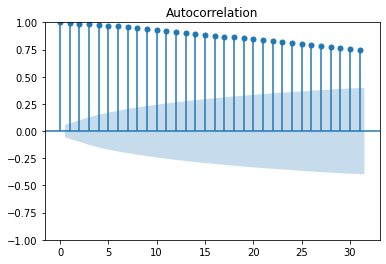

Stock ad_Close_8198


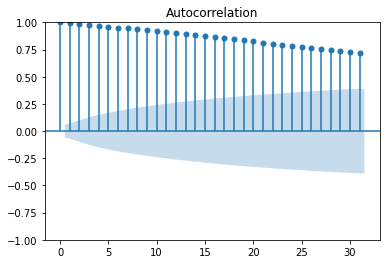

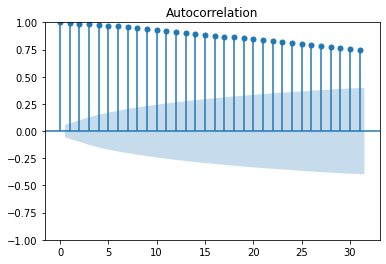

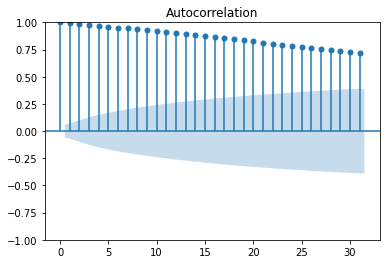

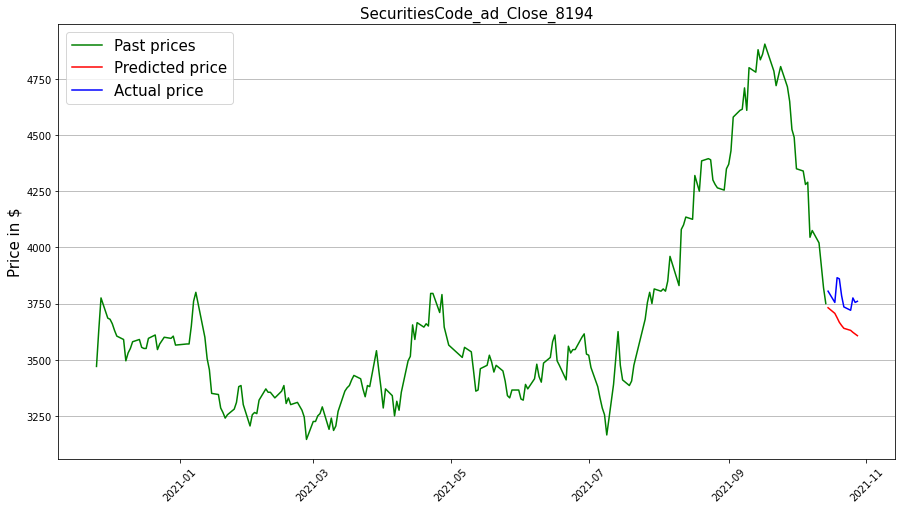

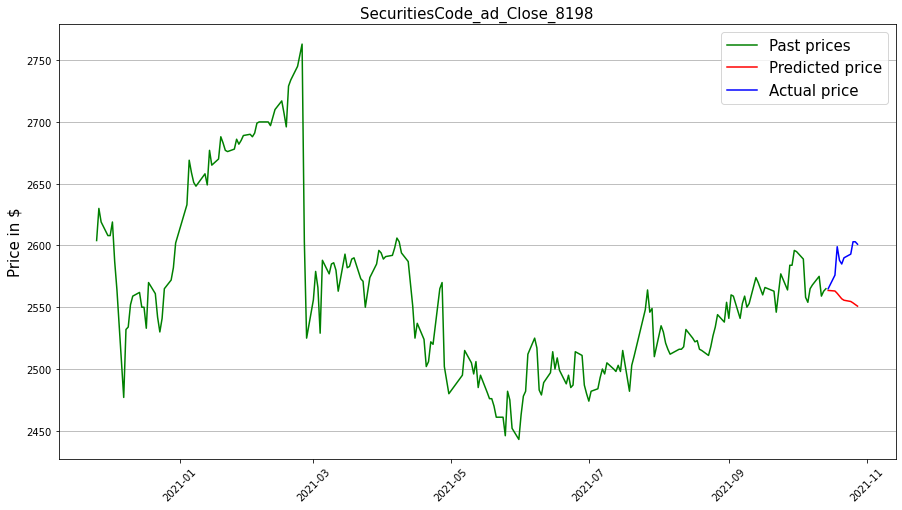

ad_Close_8194 has a MAPE score of : 3.32 %
ad_Close_8198 has a MAPE score of : 1.28 %
The average MAPE score is : 2.3 %


,ad_Close_8194,ad_Close_8198
Date,,
2021-10-15,3731.357041,2563.610184
2021-10-18,3706.301800,2563.149148
2021-10-19,3687.096429,2561.263748
2021-10-20,3666.444088,2559.054920
2021-10-21,3652.201847,2556.852021
2021-10-22,3639.720316,2555.672372
2021-10-25,3630.610255,2554.666125
2021-10-26,3621.851802,2553.518595
2021-10-27,3614.402775,2552.181401


In [221]:
var(train_data, stock_count=2, plot_predicton=True)

In [222]:
train_data.tail()

,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,...,Month_sin,Month_cos,Year_sin,Year_cos,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
2328248,2021-10-22,8185,0.0,0,764.0,771.0,761.0,765.0,76000.0,0.006545,...,0.548860,0.835914,-0.937261,0.348629,-2.544000e+09,4.462800e+10,-5.700457,639.534884,91.077239,287.034524
2328249,2021-10-25,8185,0.0,0,768.0,769.0,763.0,764.0,54500.0,-0.002601,...,0.932296,0.361696,-0.918029,0.396514,-2.544000e+09,4.462800e+10,-5.700457,639.534884,91.077239,287.034524
2328250,2021-10-26,8185,0.0,0,761.0,772.0,760.0,769.0,87100.0,-0.011734,...,0.986661,0.162788,-0.911072,0.412247,-2.544000e+09,4.462800e+10,-5.700457,639.534884,91.077239,287.034524
2328251,2021-10-27,8185,0.0,0,769.0,773.0,767.0,767.0,45900.0,0.007916,...,0.999073,-0.043041,-0.903846,0.427858,-2.544000e+09,4.462800e+10,-5.700457,639.534884,91.077239,287.034524
2328252,2021-10-28,8185,0.0,0,763.0,765.0,758.0,758.0,98000.0,0.009162,...,0.969005,-0.247040,-0.896352,0.443343,-2.544000e+09,4.462800e+10,-5.700457,639.534884,91.077239,287.034524


In [226]:
train_data_1y = train_data.query('@train_data.index >= 2020-10-28')

In [228]:
train_data_1y.shape

(2282315, 62)

100%|██████████| 2/2 [00:00<00:00, 127.43it/s]


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.92      14.93*   3.007e+06       14.92
1        14.91       14.93   2.981e+06      14.92*
2        14.90       14.95   2.965e+06       14.92
3       14.90*       14.96  2.960e+06*       14.92
4        14.90       14.98   2.965e+06       14.93
5        14.91       15.00   2.982e+06       14.94
6        14.91       15.02   2.981e+06       14.95
7        14.91       15.04   2.989e+06       14.96
8        14.92       15.07   3.008e+06       14.97
9        14.91       15.07   2.983e+06       14.97
10       14.91       15.09   2.983e+06       14.98
11       14.91       15.11   2.996e+06       14.99
12       14.92       15.14   3.013e+06       15.00
--------------------------------------------------
Stock ad_Close_8194


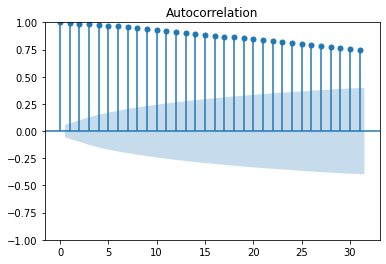

Stock ad_Close_8198


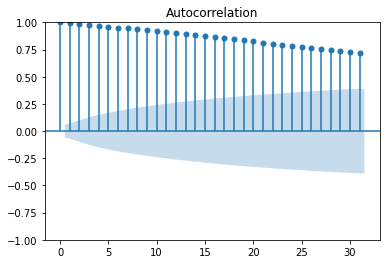

error


UnboundLocalError: local variable 'p' referenced before assignment

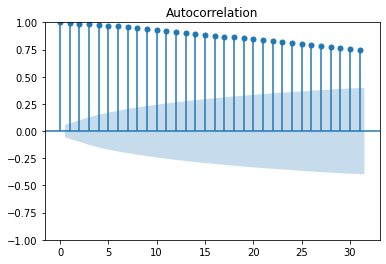

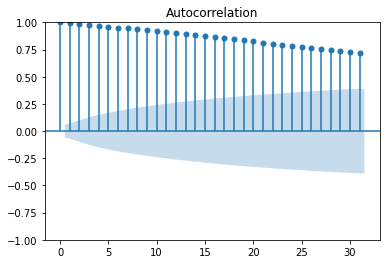

In [256]:
pred_v3 = var(train_data, stock_count=2, plot_predicton=True)

In [233]:
max(predictions['ad_Close_8198'])

2600.138955123993

Scaler 

In [259]:
def bin_columns(df):    
    extrem_low_price = []
    low_price = []
    med_price = []
    high_price = []
    extrem_high_price = []

    variables = [extrem_low_price, low_price, med_price, high_price, extrem_high_price]

    for sec in df.columns:

        if int(max(df[sec])) < 500:
            extrem_low_price.append(sec)

        if max(df[sec]) >= 500 and max(df[sec]) < 2000 :
            low_price.append(sec)

        if max(df[sec]) >= 2000 and max(df[sec]) < 4000 :
            med_price.append(sec)

        if max(df[sec]) >= 4000 and max(df[sec]) < 8000 :
            high_price.append(sec)

        if max(df[sec]) >= 8000 :
            extrem_high_price.append(sec)

    for va in variables:
        if len(va) == 0:
            continue
        elif len(va) == 1:
            if va == extrem_low_price:
                low_price.append(extrem_low_price[0])
                extrem_low_price = []

            elif va == low_price:
                med_price.append(low_price[0])
                low_price = []

            elif va == med_price:
                high_price.append(med_price[0])
                med_price = []

            elif va == high_price:
                extrem_high_price.append(high_price[0])
                high_price = []

            elif va == extrem_high_price:
                if len(high_price) >= 1:
                    high_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(med_price) >= 1:
                    med_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(low_price) >= 1:
                    low_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(extrem_low_price) >= 1:
                    extrem_low_price.append(extrem_high_price[0])
                    extrem_high_price = []

    return extrem_low_price, low_price, med_price, high_price, extrem_high_price

In [249]:
extrem_low_price, low_price, med_price, high_price, extrem_high_price = bin_columns(pred_v3)

In [300]:
def binned_var(df, stock_count=3, feature= 'ad_Close', drop_na = True, drop_axis =1):

    df = transform(df, amount=stock_count, feature=feature)
    if drop_na == True:
        df.dropna(axis = drop_axis, inplace=True)

    extrem_low_price, low_price, med_price, high_price, extrem_high_price = bin_columns(df)
            
    df_ex_low = df[extrem_low_price]
    df_low = df[low_price]
    df_med = df[med_price]
    df_high = df[high_price]
    df_ex_high = df[extrem_high_price]

    return df_ex_low, df_low, df_med, df_high, df_ex_high

In [322]:
def var(df, split = 10, range = 'y', metric = 'MAPE', exog = None, feature = 'ad_Close', stock_count = 3, drop_na = True, drop_axis = 1, maxlags = 12, plot_predicton = False, ml_flow = False):
    """_summary_

    Args:
        df (_type_): _timeseries Dataframe needed_

        split (str, optional): _Days to predict_. Defaults to '10'.

        range (str, optional): _Range of years for the train data_. Defaults to 'y'.

        metric (str, optional): _Metric chosen _. Defaults to 'MAPE'.

        exog (_type_, optional): _External data that should be considered_. Defaults to None.

        feature (str, optional): _Feature that should be predicted_. Defaults to 'ad_Close'.

        stock_count (int, optional): _amount of stocks_. Defaults to 3.

        drop_na (bool, optional): _Drops all features with NaN values_. Defaults to True.

        drop_axis (int, optional): _1 drops all columns with NaN / only drops Rows_. Defaults to 1.

        maxlags (int, optional): _Checks for the best p in X lags_. Defaults to 12.

        plot_predicton (bool, optional): _Plots the prediction_. Defaults to False.
        
        ml_flow (bool, optional): _Uploads results to ML Flow_. Defaults to False.
    """
    final = []
    final_name = []
    avg_preds = {}
    preds = {}

    if ml_flow == True:
        TRACKING_URI = open(".mlflow_uri").read().strip()


        # setting the MLFlow connection and experiment
        mlflow.set_tracking_uri(TRACKING_URI)
        mlflow.set_experiment(EXPERIMENT_NAME)
        mlflow.start_run()
        run = mlflow.active_run()

    df = transform(df, amount=stock_count, feature=feature)
    if drop_na == True:
        df.dropna(axis = drop_axis, inplace=True)

    extrem_low_price, low_price, med_price, high_price, extrem_high_price = bin_columns(df)
            
    df_ex_low = df[extrem_low_price]
    df_low = df[low_price]
    df_med = df[med_price]
    df_high = df[high_price]
    df_ex_high = df[extrem_high_price]

    #return df_ex_low, df_low, df_med, df_high, df_ex_high

    
    curr_var = [df_ex_low, df_low, df_med, df_high, df_ex_high]
    curr_var_name = ["df_ex_low", "df_low", "df_med", "df_high", "df_ex_high"]

    for dfs,names in zip(curr_var, curr_var_name):
        if dfs.shape[1] > 1:
            final.append(dfs)
            final_name.append(names)

    #display(final_name)
    
    for df_part, name in zip(final,final_name):

        #display(name, df_part)
        
        train_df = df_part[:-split]
        test_df = df_part[-split:]

        df_differenced = train_df.diff().dropna()

        model = VAR(df_differenced)
        x = model.select_order(maxlags=maxlags)
        print(x.summary())

        for i in train_df.columns:
            print(f"Stock {i}")
            display(plot_acf(train_df[i]))


        try:
            p = int(input(f"Enter p depending on AIC-Score 0 - {maxlags}"))
            q = int(input("Enter q based on acf plot"))
        except ValueError:
            print('error')


        order = (p,q)

        with tf.device('/cpu:0'):
            var_model = VARMAX(train_df, order=order, enforce_stationarity=True, exog=exog)
            model_fitted = var_model.fit(disp=False)
            model_fitted.summary()
        
        n_forcast = split-1
        start_point = len(train_df)

        pred = model_fitted.get_prediction(start=start_point, end=(start_point+n_forcast))

        predictions = pred.predicted_mean

        predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

        if plot_predicton == True:
            for i in predictions.columns:

                plt.figure(figsize=(15,8))

                sns.lineplot(train_df.index[950:], train_df[i][950:], color="green")
                sns.lineplot(predictions.index, predictions[i], color="red")
                sns.lineplot(test_df.index, test_df[i], color="blue")

                plt.ylabel("Price in $",fontsize=15)
                plt.xlabel("",fontsize=1)
                plt.yticks(size = 10)
                plt.xticks(size = 10, rotation = 45)
                plt.title('SecuritiesCode_' + i, fontsize = 15)
                plt.legend(['Past prices','Predicted price', 'Actual price'], fontsize = 15)
                plt.grid(axis='y')
                plt.show()

        if metric == "RMSE":
            average_RMSE_test = []
            for i in predictions.columns:
                cur_rmse = mse(y_pred=predictions[i], y_true=test_df[i], squared=False)
                average_RMSE_test.append(cur_rmse)
                print(f"{i} has a RMSE score of : {cur_rmse} %")
            average_RMSE_test = round(sum(average_RMSE_test)/len(average_RMSE_test),2)
            print(f"The average RMSE score is : {average_RMSE_test} %")

        if metric == "MAPE":
            average_MAPE_test = []
            for i in predictions.columns:
                cur = round((MAPE(y_pred=predictions[i], y_true=test_df[i]))*100,2) 
                average_MAPE_test.append(cur)
                print(f"{i} has a MAPE score of : {cur} %") 
            average_MAPE_test = round(sum(average_MAPE_test)/len(average_MAPE_test),2)
            print(f"The average MAPE score is : {average_MAPE_test} %")

        model_type = 'VARMAX'

        if ml_flow == True:
            params = {
            "model": model_type,
            "stock_count": stock_count,
            "split_size": split,
            "selected_order_p/q": order,
            "enforce_stationarity": True
            }

            #logging params to mlflow
            mlflow.log_params(params)
            #setting tags
            mlflow.set_tag("running_from_jupyter", "True")
            #logging metrics
            if metric == "RMSE":
                mlflow.log_metric("test-" + "avg_RMSE", average_RMSE_test)
                mlflow.end_run()
            else:
                mlflow.log_metric("test-" + "avg_MAPE", average_MAPE_test)
                mlflow.end_run()

        if metric == "RMSE":
            avg_preds.update({f'{name}_avg_RMSE': average_RMSE_test})
        else:
            avg_preds.update({f'{name}_avg_MAPE': average_MAPE_test})

        preds.update({f'{name}': predictions})
        
    return avg_preds, preds


In [309]:
train_data.shape

(2284275, 62)

100%|██████████| 10/10 [00:00<00:00, 111.69it/s]


['df_low', 'df_med', 'df_high']

'df_low'

,ad_Close_8202,ad_Close_8203,ad_Close_8214,ad_Close_8217
Date,,,,
2017-01-04,754.0,423.0,1463.0,1186.0
2017-01-05,766.0,422.0,1456.0,1178.0
2017-01-06,750.0,420.0,1445.0,1163.0
2017-01-10,737.0,419.0,1445.0,1162.0
2017-01-11,738.0,416.0,1452.0,1158.0
...,...,...,...,...
2021-10-22,175.0,622.0,692.0,1104.0
2021-10-25,173.0,610.0,673.0,1093.0
2021-10-26,184.0,605.0,680.0,1099.0


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       22.14*      22.16*  4.124e+09*      22.15*
1        22.15       22.23   4.149e+09       22.18
2        22.15       22.31   4.186e+09       22.21
3        22.16       22.38   4.188e+09       22.24
4        22.17       22.47   4.248e+09       22.28
5        22.17       22.54   4.267e+09       22.31
6        22.17       22.60   4.229e+09       22.33
7        22.17       22.67   4.234e+09       22.36
8        22.17       22.74   4.233e+09       22.38
9        22.18       22.82   4.282e+09       22.42
10       22.18       22.90   4.312e+09       22.46
11       22.20       22.99   4.372e+09       22.50
12       22.21       23.06   4.404e+09       22.53
--------------------------------------------------
Stock ad_Close_8202


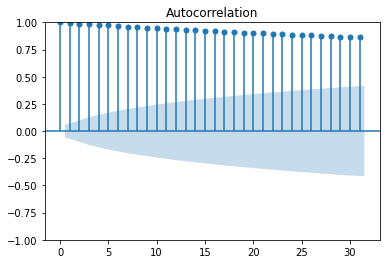

Stock ad_Close_8203


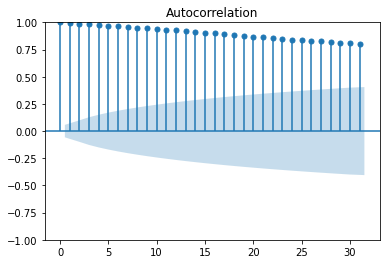

Stock ad_Close_8214


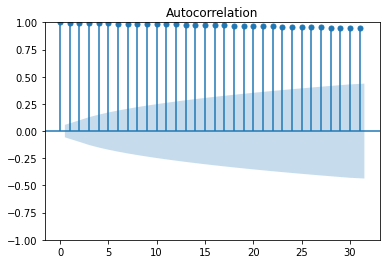

Stock ad_Close_8217


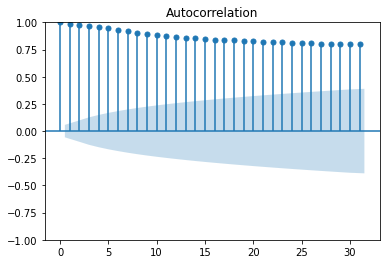

ad_Close_8202 has a MAPE score of : 2.27 %
ad_Close_8203 has a MAPE score of : 1.55 %
ad_Close_8214 has a MAPE score of : 3.38 %
ad_Close_8217 has a MAPE score of : 2.02 %
The average MAPE score is : 2.31 %


'df_med'

,ad_Close_8198,ad_Close_8200,ad_Close_8218
Date,,,
2017-01-04,1902.0,2298.0,2736.0
2017-01-05,1907.0,2299.0,2794.0
2017-01-06,1905.0,2302.0,2789.0
2017-01-10,1906.0,2323.0,2729.0
2017-01-11,1915.0,2324.0,2770.0
...,...,...,...
2021-10-22,2590.0,2222.0,2709.0
2021-10-25,2593.0,2210.0,2709.0
2021-10-26,2603.0,2183.0,2721.0


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.98      21.00*   1.296e+09      20.99*
1        20.97       21.02   1.279e+09       20.99
2        20.97       21.06   1.277e+09       21.00
3       20.97*       21.10  1.275e+09*       21.02
4        20.98       21.15   1.287e+09       21.04
5        20.98       21.19   1.294e+09       21.06
6        20.99       21.24   1.307e+09       21.08
7        21.00       21.29   1.319e+09       21.11
8        21.00       21.33   1.319e+09       21.12
9        21.01       21.38   1.334e+09       21.15
10       21.02       21.42   1.340e+09       21.17
11       21.02       21.47   1.345e+09       21.19
12       21.01       21.50   1.338e+09       21.20
--------------------------------------------------
Stock ad_Close_8198


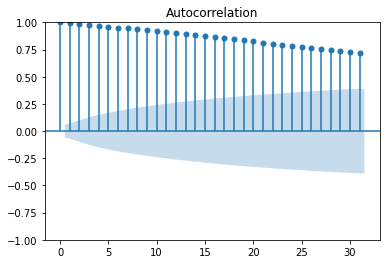

Stock ad_Close_8200


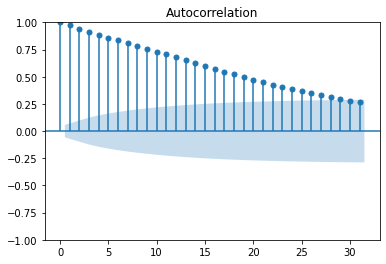

Stock ad_Close_8218


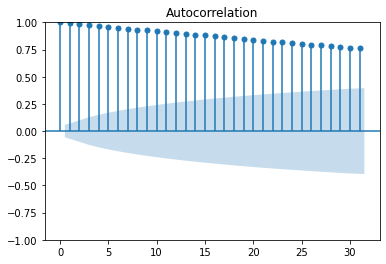

ad_Close_8198 has a MAPE score of : 1.53 %
ad_Close_8200 has a MAPE score of : 3.44 %
ad_Close_8218 has a MAPE score of : 3.09 %
The average MAPE score is : 2.69 %


'df_high'

,ad_Close_8194,ad_Close_8219,ad_Close_8227
Date,,,
2017-01-04,3380.0,4165.0,15200.0
2017-01-05,3375.0,4150.0,15270.0
2017-01-06,3365.0,4155.0,15370.0
2017-01-10,3295.0,4085.0,15490.0
2017-01-11,3275.0,4070.0,15400.0
...,...,...,...
2021-10-22,3735.0,801.0,9660.0
2021-10-25,3720.0,785.0,9400.0
2021-10-26,3775.0,795.0,9740.0


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       25.96*      25.98*  1.884e+11*      25.97*
1        25.97       26.02   1.891e+11       25.99
2        25.98       26.07   1.914e+11       26.01
3        25.99       26.12   1.928e+11       26.03
4        25.99       26.17   1.947e+11       26.06
5        26.00       26.21   1.964e+11       26.08
6        26.01       26.26   1.971e+11       26.10
7        26.01       26.30   1.983e+11       26.12
8        26.02       26.35   1.995e+11       26.14
9        26.03       26.40   2.016e+11       26.17
10       26.04       26.44   2.029e+11       26.19
11       26.05       26.49   2.049e+11       26.21
12       26.06       26.54   2.070e+11       26.24
--------------------------------------------------
Stock ad_Close_8194


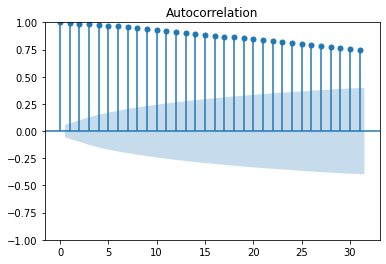

Stock ad_Close_8219


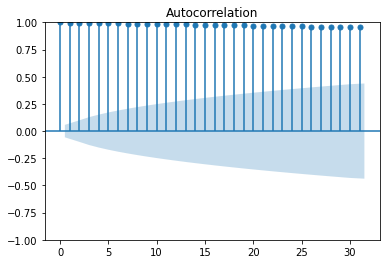

Stock ad_Close_8227


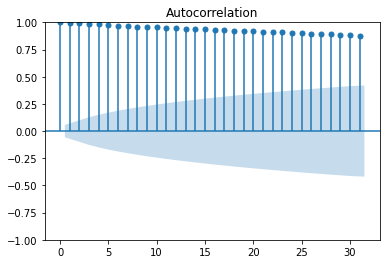

ad_Close_8194 has a MAPE score of : 1.38 %
ad_Close_8219 has a MAPE score of : 2.67 %
ad_Close_8227 has a MAPE score of : 2.37 %
The average MAPE score is : 2.14 %


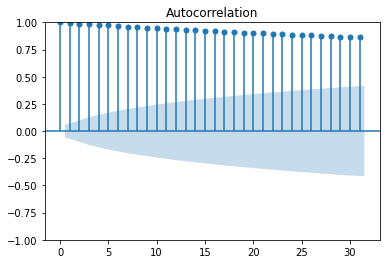

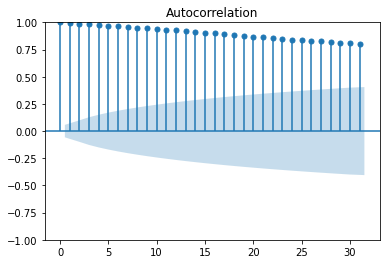

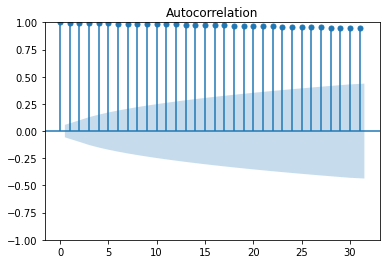

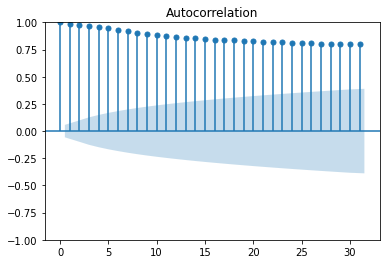

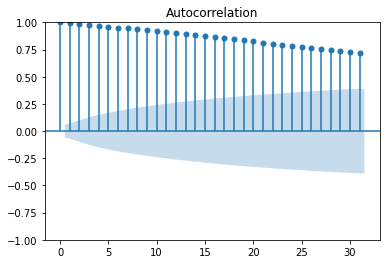

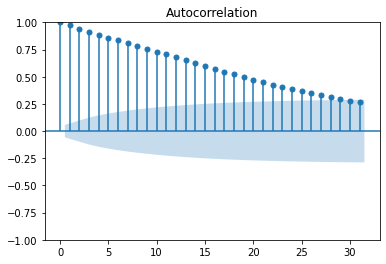

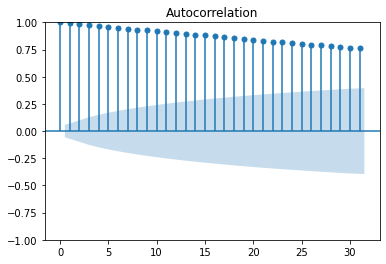

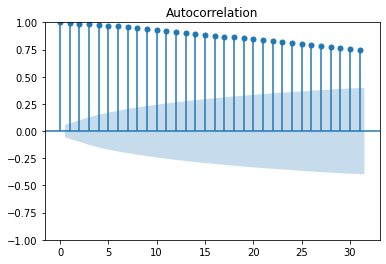

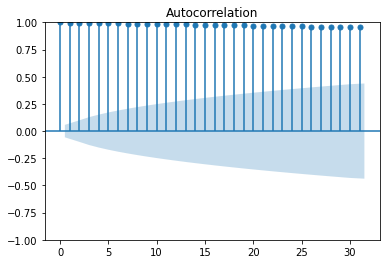

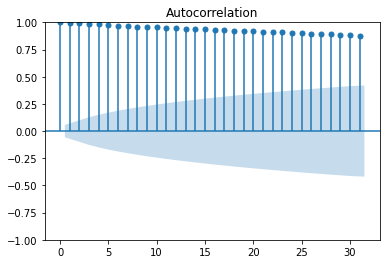

In [327]:
avg, pred = var(train_data, stock_count=10)

# 3 Auto-Gridsearch VAR Model

In [ ]:
def bin_columns(df):    
    extrem_low_price = []
    low_price = []
    med_price = []
    high_price = []
    extrem_high_price = []

    variables = [extrem_low_price, low_price, med_price, high_price, extrem_high_price]

    for sec in df.columns:

        if int(max(df[sec])) < 500:
            extrem_low_price.append(sec)

        if max(df[sec]) >= 500 and max(df[sec]) < 2000 :
            low_price.append(sec)

        if max(df[sec]) >= 2000 and max(df[sec]) < 4000 :
            med_price.append(sec)

        if max(df[sec]) >= 4000 and max(df[sec]) < 8000 :
            high_price.append(sec)

        if max(df[sec]) >= 8000 :
            extrem_high_price.append(sec)

    for va in variables:
        if len(va) == 0:
            continue
        elif len(va) == 1:
            if va == extrem_low_price:
                low_price.append(extrem_low_price[0])
                extrem_low_price = []

            elif va == low_price:
                med_price.append(low_price[0])
                low_price = []

            elif va == med_price:
                high_price.append(med_price[0])
                med_price = []

            elif va == high_price:
                extrem_high_price.append(high_price[0])
                high_price = []

            elif va == extrem_high_price:
                if len(high_price) >= 1:
                    high_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(med_price) >= 1:
                    med_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(low_price) >= 1:
                    low_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(extrem_low_price) >= 1:
                    extrem_low_price.append(extrem_high_price[0])
                    extrem_high_price = []

    return extrem_low_price, low_price, med_price, high_price, extrem_high_price

Binning different stockes based on price range, to work against extreme fluctuation forecast on low and high priced stocks

In [ ]:
def transform(df, amount = 3 ,feature = 'ad_Close', first = True, selected = None):
    from functions import df_security_code
    feat = ['Date', 'SecuritiesCode' , feature]
    df = df[feat]
    con_df = pd.DataFrame()
    if selected == None:
        unique_codes = df.SecuritiesCode.unique()[:amount]
    else:
        unique_codes = selected

    for cod in tqdm(unique_codes):
        if cod != 4684 or cod != 4686: 
            df_code = df_security_code(df, cod)
            df_code = df_code[['Date', feature]].set_index(['Date'])
            df_code = df_code.rename(columns = {feature: 'ad_Close_'+str(cod)})
            con_df = pd.concat([con_df, df_code], axis=1)
            
    return con_df

Transforming current data into a processable form for the VAR model

In [ ]:
def var_gridsearch(df, split = 10, metric = 'MAPE',selected=None , exog = None, feature = 'ad_Close', stock_count = 3, drop_na = True, drop_axis = 1, maxlags = 12, plot_predicton = False, ml_flow = False):
    """_summary_

    Args:
        df (_type_): _timeseries Dataframe needed_

        split (str, optional): _Days to predict_. Defaults to '10'.

        range (str, optional): _Range of years for the train data_. Defaults to 'y'.

        metric (str, optional): _Metric chosen _. Defaults to 'MAPE'.

        exog (_type_, optional): _External data that should be considered_. Defaults to None.

        feature (str, optional): _Feature that should be predicted_. Defaults to 'ad_Close'.

        stock_count (int, optional): _amount of stocks_. Defaults to 3.

        drop_na (bool, optional): _Drops all features with NaN values_. Defaults to True.

        drop_axis (int, optional): _1 drops all columns with NaN / only drops Rows_. Defaults to 1.

        maxlags (int, optional): _Checks for the best p in X lags_. Defaults to 12.

        plot_predicton (bool, optional): _Plots the prediction_. Defaults to False.
        
        ml_flow (bool, optional): _Uploads results to ML Flow_. Defaults to False.
    """
    final = []
    final_name = []
    avg_preds = {}
    preds = {}

    if ml_flow == True:
        TRACKING_URI = open(".mlflow_uri").read().strip()


        # setting the MLFlow connection and experiment
        mlflow.set_tracking_uri(TRACKING_URI)
        mlflow.set_experiment(EXPERIMENT_NAME)
        mlflow.start_run()
        run = mlflow.active_run()

    df = transform(df, amount=stock_count, feature=feature, selected=selected)
    if drop_na == True:
        df.dropna(axis = drop_axis, inplace=True)

    extrem_low_price, low_price, med_price, high_price, extrem_high_price = bin_columns(df)
            
    df_ex_low = df[extrem_low_price]
    df_low = df[low_price]
    df_med = df[med_price]
    df_high = df[high_price]
    df_ex_high = df[extrem_high_price]

    #return df_ex_low, df_low, df_med, df_high, df_ex_high

    
    curr_var = [df_ex_low, df_low, df_med, df_high, df_ex_high]
    curr_var_name = ["df_ex_low", "df_low", "df_med", "df_high", "df_ex_high"]

    for dfs,names in zip(curr_var, curr_var_name):
        if dfs.shape[1] > 1:
            final.append(dfs)
            final_name.append(names)

    #display(final_name)
    
    for df_part, name in zip(final,final_name):

        #display(name, df_part)
        curr_data = {}
        for i in df_part.columns:
            curr_data.update({f'{i}': df[i].diff()})

        df_transformed = pd.DataFrame(curr_data).dropna()
        df_train = df_transformed.iloc[:-split]
        test_results = {}

        print(f'Dataframe: {name}')

        for p in tqdm(range(3)):
            for q in range(5):
                if p == 0 and q == 0:
                    continue
                    
                print(f'Testing Order: p = {p}, q = {q}')
                convergence_error = stationarity_error = 0
                
                try:
                    model = VARMAX(df_train, order=(p,q), trend='n')
                    model_result = model.fit(maxiter=1000, disp=False)
                        
                except LinAlgError:
                    convergence_error += 1
                        
                except ValueError:
                    stationarity_error += 1


                test_results[(p, q)] = [model_result.aic,
                                        model_result.bic,
                                        convergence_error,
                                        stationarity_error]

        test_results = pd.DataFrame(test_results).T
        test_results.columns = ['AIC', 'BIC', 'convergence', 'stationarity']
        test_results.index.names = ['p', 'q']

        order = test_results['AIC'].idxmin()
        
        train_df = df_part[:-split]
        test_df = df_part[-split:]


        with tf.device('/cpu:0'):
            var_model = VARMAX(train_df, order=order, enforce_stationarity=True, exog=exog)
            model_fitted = var_model.fit(disp=False)
            #model_fitted.summary()
        
        n_forcast = split-1
        start_point = len(train_df)

        pred = model_fitted.get_prediction(start=start_point, end=(start_point+n_forcast))

        predictions = pred.predicted_mean

        

        predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

        if plot_predicton == True:
            for i in predictions.columns:

                plt.figure(figsize=(15,8))

                sns.lineplot(train_df.index[950:], train_df[i][950:], color="green")
                sns.lineplot(predictions.index, predictions[i], color="red")
                sns.lineplot(test_df.index, test_df[i], color="blue")

                plt.ylabel("Price in $",fontsize=15)
                plt.xlabel("",fontsize=1)
                plt.yticks(size = 10)
                plt.xticks(size = 10, rotation = 45)
                plt.title('SecuritiesCode_' + i, fontsize = 15)
                plt.legend(['Past prices','Predicted price', 'Actual price'], fontsize = 15)
                plt.grid(axis='y')
                plt.show()

        if metric == "RMSE":
            average_RMSE_test = []
            for i in predictions.columns:
                cur_rmse = mse(y_pred=predictions[i], y_true=test_df[i], squared=False)
                average_RMSE_test.append(cur_rmse)
                print(f"{i} has a RMSE score of : {cur_rmse} %")
            average_RMSE_test = round(sum(average_RMSE_test)/len(average_RMSE_test),2)
            print(f"The average RMSE score is : {average_RMSE_test} %")

        if metric == "MAPE":
            average_MAPE_test = []
            for i in predictions.columns:
                cur = round((MAPE(y_pred=predictions[i], y_true=test_df[i]))*100,2) 
                average_MAPE_test.append(cur)
                print(f"{i} has a MAPE score of : {cur} %") 
            average_MAPE_test = round(sum(average_MAPE_test)/len(average_MAPE_test),2)
            print(f"The average MAPE score is : {average_MAPE_test} %")

        model_type = 'VARMAX'

        if ml_flow == True:
            params = {
            "model": model_type,
            "stock_count": stock_count,
            "split_size": split,
            "selected_order_p/q": order,
            "enforce_stationarity": True
            }

            #logging params to mlflow
            mlflow.log_params(params)
            #setting tags
            mlflow.set_tag("running_from_jupyter", "True")
            #logging metrics
            if metric == "RMSE":
                mlflow.log_metric("test-" + "avg_RMSE", average_RMSE_test)
                mlflow.end_run()
            else:
                mlflow.log_metric("test-" + "avg_MAPE", average_MAPE_test)
                mlflow.end_run()

        if metric == "RMSE":
            avg_preds.update({f'{name}_avg_RMSE': average_RMSE_test})
        else:
            avg_preds.update({f'{name}_avg_MAPE': average_MAPE_test})

        preds.update({f'{name}': predictions})
        
    return avg_preds, preds

VAR Gridsearch with multiple internal functions 

-> Notebook VAR2